Initialise code for google colab

Mount google drive

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
import tensorflow as tf
print(tf.__version__)
import tensorflow_addons as tfa
print(tfa.__version__)

2.12.0
0.20.0


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [2]:
!pip install tensorflow-addons==0.20

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 43.4 MB/s eta 0:00:00


Create data base files under google colab environment

In [ ]:
!rm -rf /content/data_split/

In [4]:
!unzip -q '/content/drive/MyDrive/data_split.zip' -d '/content/'

For Luc because my archive made on mac create a __MACOSX folder

In [5]:
%rm -rf /content/__MACOSX

Define working directory to our jupyter repertory:
* because path to the different repertories (./data, ./output...) are define relatevly to jupyter one
* let import _mypath which add ./lib to python path in order to import our own define libraries


In [1]:
# for google colab use
%cd /content/drive/MyDrive/inarix/jupyter
db_work_dir = '/content'

/content/drive/MyDrive/inarix/jupyter


In [ ]:
# for local use
db_work_dir = '..'

In [2]:
import _mypath
import os
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications import DenseNet201
import joblib

%load_ext autoreload
%autoreload 1

In [3]:
%aimport database.data_path
%aimport database.dataset

from database.data_path import build_data_paths
from database.dataset import build_dataset


Model parameters

In [4]:
batch_size = 16
image_height = 256
image_width = 256
image_size = [image_height, image_width]
input_shape = (image_height, image_width, 3)

learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 100

label_smoothing = 0.05
patience = 5
min_delta = 0.005

# data augmentation
scale = 1. / 255.
flip = "horizontal_and_vertical"
rotation_factor = 10. / 360.
zoom_height_factor = 0.2
zoom_width_factor = 0.2

mlp_head_units = [512, 256]  # Size of the dense layers of the final classifier
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = layers.Dense(units, activation=tf.nn.gelu)(x)
        x = layers.Dropout(dropout_rate)(x)
    return x

Build paths and variables for reading data base hierarchy

In [5]:
# input
db_name = 'data_split'
db_path = os.path.join(db_work_dir, db_name)

# output
output_path = os.path.join('..', 'output', 'transfer_learning')
if not os.path.exists(output_path):
    os.makedirs(output_path, exist_ok=True)

log_path = os.path.join(output_path, 'log')
if not os.path.exists(log_path):
    os.makedirs(log_path, exist_ok=True)

ckpt_path = os.path.join(output_path, 'ckpt')
if not os.path.exists(ckpt_path):
    os.makedirs(ckpt_path, exist_ok=True)

metric_path = os.path.join(output_path, 'metric')
if not os.path.exists(metric_path):
    os.makedirs(metric_path, exist_ok=True)


Structure to manage paths in data base

In [6]:
grain_types = ["hard_wheat", "soft_wheat", "barley", "corn"]
n_labels = len(grain_types)
print(n_labels)

data_paths_device1, labels_device1 = build_data_paths(db_path, grain_types, ["device1"])
print(data_paths_device1)
data_paths_device2, labels_device2 = build_data_paths(db_path, grain_types, ["device2"])
print(data_paths_device2)


4
['/content/data_split/hard_wheat_device1', '/content/data_split/soft_wheat_device1', '/content/data_split/barley_device1', '/content/data_split/corn_device1']
['/content/data_split/soft_wheat_device2', '/content/data_split/barley_device2']


Create tf Dataset

In [7]:
ds_device1 = build_dataset(data_paths_device1, labels_device1, image_size=image_size, shuffle=False)
print(ds_device1)
print(labels_device1)

ds_device2 = build_dataset(data_paths_device2, labels_device2, image_size=image_size, shuffle=False)
print(ds_device2)
print(labels_device2)

Found 832 files belonging to 1 classes.
Found 832 files belonging to 1 classes.
Found 1224 files belonging to 1 classes.
Found 1224 files belonging to 1 classes.
<_ConcatenateDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.int32, name=None))>
[[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1]]
Found 264 files belonging to 1 classes.
Found 264 files belonging to 1 classes.
<_ConcatenateDataset element_spec=(TensorSpec(shape=(256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.int32, name=None))>
[[0, 1, 0, 0], [0, 0, 1, 0]]


In [8]:
dataset_size = len(ds_device1)
print(dataset_size)
train_size = int(0.8 * dataset_size)
valid_size = int(0.10 * dataset_size)

ds = ds_device1.shuffle(dataset_size, seed=123, reshuffle_each_iteration=False)
ds_train = ds.take(train_size)
ds_test = ds.skip(train_size)
ds_valid = ds_test.take(valid_size)
ds_test = ds_test.skip(valid_size)


4112


Data augmentation

In [9]:
data_augmentation = keras.Sequential(
    [
      layers.Rescaling(scale=scale),
      layers.RandomFlip(flip),
      layers.RandomRotation(rotation_factor),
      layers.RandomZoom(height_factor=zoom_height_factor, width_factor=zoom_width_factor),
    ],
    name='data_augmentation'
)
norm_layer = layers.Normalization()


Pretrained model

In [10]:
baseModel = VGG16(weights="imagenet", include_top=False, input_shape=input_shape)
# baseModel = VGG19(weights="imagenet", include_top=False,input_tensor=layers.Input(shape=(image_size, image_size, 3)))
# baseModel = DenseNet201(weights="imagenet", include_top=False,input_tensor=layers.Input(shape=(image_size, image_size, 3)))
for layer in baseModel.layers:
    layer.trainable = False


inputs = layers.Input(shape=input_shape)
augmented = data_augmentation(inputs)
base = baseModel(augmented)
head = layers.AveragePooling2D(pool_size=(8, 8))(base)
head = layers.Flatten(name="flatten")(head)
features = mlp(head, hidden_units=mlp_head_units, dropout_rate=0.5)

# Classify outputs.
softmax = layers.Dense(n_labels, activation='softmax', kernel_initializer='random_normal')(features)

# Create the Keras model.
model = keras.Model(inputs=inputs, outputs=softmax)


In [11]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 data_augmentation (Sequenti  (None, 256, 256, 3)      0         
 al)                                                             
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 average_pooling2d (AverageP  (None, 1, 1, 512)        0         
 ooling2D)                                                       
                                                                 
 flatten (Flatten)           (None, 512)               0         
                                                                 
 dense (Dense)               (None, 512)               262656

In [13]:
from run_exp.standard import run_experiment

model_name = 'transfer_leraning_VGG16_2_training'
run_experiment(
  model,
  ds_train, ds_valid, ds_test,
  batch_size=batch_size, num_epochs=num_epochs,
  learning_rate=learning_rate, weight_decay=weight_decay,
  from_logits=False, label_smoothing=label_smoothing,
  patience=patience, min_delta=min_delta,
  log_path=log_path, ckpt_path=ckpt_path,
  prefix=model_name
)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


206/206 [==============================] - ETA: 0s - loss: 0.4467 - accuracy: 0.8933
Epoch 1: val_accuracy improved from -inf to 0.84672, saving model to ../output/transfer_learning/ckpt/transfer_leraning_VGG16_2_training_weights.hdf5
206/206 [==============================] - 66s 206ms/step - loss: 0.4467 - accuracy: 0.8933 - val_loss: 0.5270 - val_accuracy: 0.8467
Epoch 2/100
206/206 [==============================] - ETA: 0s - loss: 0.4299 - accuracy: 0.9000
Epoch 2: val_accuracy improved from 0.84672 to 0.85645, saving model to ../output/transfer_learning/ckpt/transfer_leraning_VGG16_2_training_weights.hdf5
206/206 [==============================] - 48s 195ms/step - loss: 0.4299 - accuracy: 0.9000 - val_loss: 0.5407 - val_accuracy: 0.8564
Epoch 3/100
206/206 [==============================] - ETA: 0s - loss: 0.4087 - accuracy: 0.9146
Epoch 3: val_accuracy improved from 0.85645 to 0.89051, saving model to ../output/transfer_learning/ckpt/transfer_leraning_VGG16_2_training_weights.hd

In [14]:
model_name = 'transfer_leraning_VGG16_2_training'
checkpoint_filename = os.path.join(ckpt_path, model_name + '_weights.hdf5')
model.load_weights(checkpoint_filename)


In [15]:
%aimport run_exp.test
from run_exp.test import compile_test_model

y_test_pd, y_pred_pd, accuracy, conf_mat, report = compile_test_model(
    model,
    ds_test,
    batch_size,
    from_logits=False,
    label_smoothing=label_smoothing
)

print(f"Test accuracy: {round(accuracy * 100, 2)}%")

print(report)
f_name = os.path.join(metric_path, model_name + '_report.txt')
with open(f_name, "w") as text_file:
  text_file.write(report)

conf_mat
f_name = os.path.join(metric_path, model_name + '_conf_mat.joblib')
joblib.dump(conf_mat, f_name)


26/26 [==============================] - 15s 183ms/step
Test accuracy: 92.23%
              precision    recall  f1-score   support

           0       0.93      0.77      0.84        87
           1       0.77      0.95      0.85        83
           2       0.99      0.98      0.98       123
           3       0.97      0.96      0.97       119

    accuracy                           0.92       412
   macro avg       0.92      0.91      0.91       412
weighted avg       0.93      0.92      0.92       412



['../output/transfer_learning/metric/transfer_leraning_VGG16_2_training_conf_mat.joblib']

In [16]:
%aimport run_exp.test
from run_exp.test import compile_test_model

y_test_pd, y_pred_pd, accuracy, conf_mat, report = compile_test_model(
    model,
    ds_device2, batch_size,
    from_logits=False,
    label_smoothing=label_smoothing
)

print(f"Test accuracy: {round(accuracy * 100, 2)}%")

print(report)
f_name = os.path.join(metric_path, model_name + '_device2_report.txt')
with open(f_name, "w") as text_file:
  text_file.write(report)

conf_mat
f_name = os.path.join(metric_path, model_name + '_device2_conf_mat.joblib')
joblib.dump(conf_mat, f_name)


33/33 [==============================] - 3s 82ms/step
Test accuracy: 97.16%
              precision    recall  f1-score   support

           1       1.00      0.95      0.97       264
           2       0.95      1.00      0.97       264

    accuracy                           0.97       528
   macro avg       0.97      0.97      0.97       528
weighted avg       0.97      0.97      0.97       528



['../output/transfer_learning/metric/transfer_leraning_VGG16_2_training_device2_conf_mat.joblib']

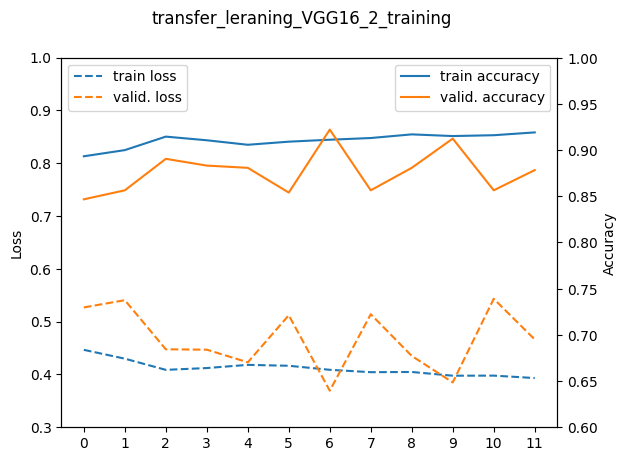

In [22]:
learning_df = pd.read_csv(os.path.join(log_path, model_name + '_log.csv'))
# print(learning_df.head(25))

fig, ax1 = plt.subplots()
fig.suptitle(model_name)

epoch = learning_df['epoch']

ax1.set_ylim(0.3, 1)
ax1.set_ylabel("Loss")
ax1.plot(epoch, learning_df['loss'], '--', label='train loss')
ax1.plot(epoch, learning_df['val_loss'], '--', label='valid. loss')
ax1.legend(loc='upper left')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
ax2.set_xticks(epoch)
ax2.set_xlabel("Num epoch")
ax2.set_ylim(0.6, 1.)
ax2.set_ylabel("Accuracy")
ax2.plot(epoch, learning_df['accuracy'], label='train accuracy')
ax2.plot(epoch, learning_df['val_accuracy'], label='valid. accuracy')
ax2.legend()

plt.savefig(os.path.join(metric_path, model_name + '_learning_curves.png'), format='png')
plt.show()


In [23]:
mix_types = ["mix"]

print(db_path)
data_paths_mix, labels_mix = build_data_paths(db_path, mix_types, ["device1"])
data_paths_mix = data_paths_mix[0]
print(data_paths_mix)


/content/data_split
/content/data_split/mix_device1


In [24]:
df_mix_path = os.path.join(data_paths_mix, "labels.csv")
print(df_mix_path)
df_mix = pd.read_csv(df_mix_path, sep=';')
df_mix

/content/data_split/mix_device1/labels.csv


,image_id,specie_pct_label
0,84293a4a-3bf0-4496-a97e-db42affd1d6a,"{'barley': 92, 'soft_wheat': 8}"
1,da4deef4-b9cc-4616-851e-0dd8f6fabf13,"{'soft_wheat': 81, 'barley': 19}"
2,f6e2b462-8f1a-473a-8c9a-6750284b7de4,"{'barley': 77, 'soft_wheat': 23}"
3,babedc24-c2e7-4225-8e25-0968c81a646b,"{'barley': 77, 'soft_wheat': 23}"
4,33b22209-1890-415c-8919-7fd847506ac7,"{'soft_wheat': 94, 'barley': 6}"
5,27da3522-fc54-47e7-9025-9e77187d76af,"{'soft_wheat': 69, 'barley': 31}"
6,b4eafb18-e6cf-45cb-b185-0db4f1eef9f2,"{'barley': 87, 'soft_wheat': 13}"
7,75a205c9-36ad-4233-99e9-e2538212dad8,"{'barley': 90, 'soft_wheat': 10}"
8,8c5a86c5-d015-48a5-9877-c8659bf3677a,"{'barley': 88, 'soft_wheat': 12}"
9,65893dab-d585-4313-b75e-bec8c5cd1794,"{'barley': 87, 'soft_wheat': 13}"


In [25]:
%aimport run_exp.test
from run_exp.test import compile_pred_model

rates = []
for image_id in df_mix['image_id']:
  image_id = image_id.strip()
  data_paths_image = os.path.join(data_paths_mix, image_id)
  ds_image = build_dataset([data_paths_image], labels_mix, image_size=image_size, shuffle=False)

  y_pred = compile_pred_model(model, ds_image, batch_size=batch_size)
  rate = np.mean(y_pred, axis=0)
  rates.append(rate)

# print(rates)
d = {
    'image_id': df_mix['image_id'],
    'specie_pct_label': [dict(zip(grain_types, rate)) for rate in rates]
}
df_rates = pd.DataFrame(data=d)
df_rates.to_csv(os.path.join(metric_path, "mix_rates.csv"), sep=';')
df_rates

Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 230ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 214ms/step
Found 4 files belonging to 1 classes.
1/1 [==============================] - 1s 1s/step
Found 4 files belonging to 1 classes.


1/1 [==============================] - 0s 216ms/step
Found 9 files belonging to 1 classes.


1/1 [==============================] - 0s 216ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 227ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 239ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 219ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 203ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 215ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 209ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 234ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 232ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 228ms/step
Found 9 files belonging to 1 classes.
1/1 [==============================] - 0s 206ms/step
Found 9 files belonging to 1 classes.

,image_id,specie_pct_label
0,84293a4a-3bf0-4496-a97e-db42affd1d6a,"{'hard_wheat': 0.011229825, 'soft_wheat': 0.00..."
1,da4deef4-b9cc-4616-851e-0dd8f6fabf13,"{'hard_wheat': 0.4516353, 'soft_wheat': 0.3401..."
2,f6e2b462-8f1a-473a-8c9a-6750284b7de4,"{'hard_wheat': 0.016280223, 'soft_wheat': 0.01..."
3,babedc24-c2e7-4225-8e25-0968c81a646b,"{'hard_wheat': 0.011920765, 'soft_wheat': 0.01..."
4,33b22209-1890-415c-8919-7fd847506ac7,"{'hard_wheat': 0.09483591, 'soft_wheat': 0.754..."
5,27da3522-fc54-47e7-9025-9e77187d76af,"{'hard_wheat': 0.2374, 'soft_wheat': 0.3994947..."
6,b4eafb18-e6cf-45cb-b185-0db4f1eef9f2,"{'hard_wheat': 0.016208854, 'soft_wheat': 0.02..."
7,75a205c9-36ad-4233-99e9-e2538212dad8,"{'hard_wheat': 0.006546882, 'soft_wheat': 0.00..."
8,8c5a86c5-d015-48a5-9877-c8659bf3677a,"{'hard_wheat': 0.010024568, 'soft_wheat': 0.00..."
9,65893dab-d585-4313-b75e-bec8c5cd1794,"{'hard_wheat': 0.016243262, 'soft_wheat': 0.01..."
